## Import Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.feature_selection import RFE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
pd.set_option('display.max_columns', None)

## Read Data and Inspect

In [28]:
# importing original data and previously worked dataframe 
train = pd.read_csv("../project_data/original_data/train.csv")
df_train = pd.read_csv("../project_data/handout_data/training_handout.csv")

In [29]:
df_train.columns

Index(['Unnamed: 0', 'brand', 'model', 'price', 'transmission', 'mileage',
       'fuelType', 'tax', 'mpg', 'engineSize', 'car_age', 'mileage_per_year'],
      dtype='object')

In [30]:
print(train.shape)
df_train.shape

(75973, 14)


(75973, 12)

In [31]:
# remove unnamed 0 column
df_train = df_train.drop(columns=['Unnamed: 0'])
df_train

,brand,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,car_age,mileage_per_year
0,vw,golf,22290,semi-auto,28421.0,petrol,NaN,11.4,2.0,4.0,7105.250000
1,toyota,yaris,13790,manual,4589.0,petrol,145.0,47.9,1.5,1.0,4589.000000
2,audi,q2,24990,semi-auto,3624.0,petrol,145.0,40.9,1.5,1.0,3624.000000
3,ford,fiesta,12500,manual,9102.0,petrol,145.0,65.7,1.0,2.0,4551.000000
4,bmw,2 series,22995,manual,1000.0,petrol,145.0,42.8,1.5,1.0,1000.000000
...,...,...,...,...,...,...,...,...,...,...,...
75968,mercedes,c class,13498,manual,14480.0,petrol,125.0,53.3,2.0,5.0,2896.000000
75969,audi,q3,12495,semi-auto,52134.0,diesel,200.0,47.9,2.0,7.0,7447.714286
75970,toyota,aygo,8399,automatic,11304.0,petrol,145.0,67.0,1.0,3.0,3768.000000
75971,audi,q3,12990,manual,69072.0,diesel,125.0,60.1,2.0,5.0,13814.400000


In [32]:
# Drop mileage per year cause i dont feel its goudd
#df_train = df_train.drop(columns=["mileage_per_year"])
#df_train

### Missing Data

In [33]:
miss = df_train.isna().sum()
mv = pd.DataFrame({"missing": miss[miss>0], "missing_%": (miss[miss>0]/len(df_train)*100).round(2)}).sort_values("missing_%", ascending=False)
if not mv.empty:
    print("\nMissing-values summary (non-zero):")
    print(mv.head(20))


Missing-values summary (non-zero):
                  missing  missing_%
tax                  8282      10.90
mpg                  7962      10.48
mileage_per_year     3645       4.80
transmission         2263       2.98
car_age              1849       2.43
mileage              1832       2.41
engineSize           1780       2.34
model                1721       2.27
fuelType             1678       2.21
brand                  43       0.06


In [34]:
# these lines are worth dog shait and are 0.06 % of data
#df_train[df_train["brand"].isnull()]

In [35]:
#df_train = df_train[df_train["brand"].notnull()]
#df_train.shape

In [36]:
#df_train[df_train["model"].isnull()]

## COLUMN TRANSFORMERS

In [37]:
class RareLabelGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, min_prop=0.005, column=None):
        self.min_prop = min_prop
        self.column = column
        self.keep_values_ = None
    def fit(self, X, y=None):
        s = X if isinstance(X, pd.Series) else pd.Series(X.iloc[:,0] if hasattr(X, "iloc") else X[:,0])
        vc = s.value_counts(dropna=False)
        total = len(s)
        keep = vc[vc / total >= self.min_prop].index
        self.keep_values_ = set(keep.tolist())
        return self
    def transform(self, X):
        s = X if isinstance(X, pd.Series) else pd.Series(X.iloc[:,0] if hasattr(X, "iloc") else X[:,0])
        return pd.DataFrame(np.where(s.isin(self.keep_values_), s, "Other"),
                            columns=[self.column if self.column else "col"])

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column): self.column = column
    def fit(self, X, y=None): return self
    def transform(self, X): return pd.DataFrame(X[self.column])

class CustomWinsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, variables, lower_bound=0.01, upper_bound=0.99):
        self.variables = variables
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.limits_ = {}

    def fit(self, X, y=None):
        for var in self.variables:
            if var in X.columns:
                lower_limit = X[var].quantile(self.lower_bound)
                upper_limit = X[var].quantile(self.upper_bound)
                self.limits_[var] = (lower_limit, upper_limit)
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for var, (lower_limit, upper_limit) in self.limits_.items():
            if var in X.columns:
                X_transformed[var] = np.clip(X_transformed[var], lower_limit, upper_limit)
        return X_transformed

In [38]:
# BaseEstimator → dá compatibilidade com pipelines, grid-search e clonagem
# TransformerMixin → fornece fit_transform() automaticamente
class Mode_Imput_By_Brand(BaseEstimator, TransformerMixin):

    """
    O objetivo com este transformer é preencher os valores nulos de cada coluna através da moda, mas primeiro, agrupar por brand.
    Como fallback, caso nao haja nenhuma linha preenchida daquela brand em especifico, depois de utilizar este transformer
    iremos utilzar o SimpleImputer.
    
    """
    
    def __init__(self, imput_cols = None , group_col = "brand"):       
        self.imput_cols = imput_cols
        self.group_col = group_col

    # é obrigatorio colocar X e y em todos os metodos de fit do sklearn
    def fit(self , X, y = None):
        X = X.copy()  # em qualquer metodo do sklearn criamos uma copia do df original, pois no pipeline é usado o mesmo df nao modificado para os vários passos
        
        if self.imput_cols is None: # sklearn nao gosta de args obrigatórios entao fazemos isto para contornar
            self.imput_cols = [col for col in X.columns if col != self.group_col]
        
        self.mode_maps_ = {}

        for col in self.imput_cols:
            mode_map = X.groupby(self.group_col)[col].agg(lambda x: x.mode().iloc[0]) 
            self.mode_maps_[col] = mode_map 

        return self # o .fit do sklearn retorna sempre o self
    
    def transform(self, X):
        X = X.copy()

        for col in self.imput_cols:
            X[col] = X[col].fillna(X[self.group_col].map(self.mode_maps_[col]))

        return X

In [39]:
feature_cols = [c for c in df_train.columns if c != "price"]

X = df_train[feature_cols].copy()
y = df_train["price"].copy()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=44, shuffle=True
)

Log the target variable since it´s a variable whit a great tail (a lot of outliers)

In [40]:
y_train_transformed = np.log1p(y_train)
y_val_transformed = np.log1p(y_val)

In [41]:
test = X_train.copy()
test["model"].isnull().sum()

1364

In [42]:
test.columns

Index(['brand', 'model', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg',
       'engineSize', 'car_age', 'mileage_per_year'],
      dtype='object')

In [43]:
imput = Mode_Imput_By_Brand(imput_cols = ["model"])
imput.fit(test)
imput.mode_maps_

{'model': brand
 audi              a3
 bmw         3 series
 ford           focus
 hyundai       tucson
 mercedes     c class
 opel           corsa
 skoda          fabia
 toyota         yaris
 vw              golf
 Name: model, dtype: object}

In [44]:
test = imput.transform(test)
test["model"].isnull().sum()
# these 37 rows need a fallback imputer, cause probably are the ones missing brand

37

## Scalling Data

Scaling

- **Why scale:** Linear/regularized models are scale-sensitive. Numeric features can have very different ranges (ex: mileage vs engine size), which biases coefficients.

- **Choice:** **StandardScaler** for numeric columns (after imputation and outlier capping).

- **StandardScaler over MinMaxScaler:** Standardization centers and normalizes variance—well-aligned with Ridge/Lasso penalties and keeps One-Hot Enconding interpretable. All scaling is fit on the training fold only within the pipeline to ensure that there are **no leakage**.

In [45]:
scaler = StandardScaler()

In [46]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]
without_model = [c for c in X_train.columns if c not in numeric_cols + ['model']]
skewness = X_train[numeric_cols].skew(numeric_only=True).sort_values(ascending=False)
log_candidates = [c for c, s in skewness.items() if np.isfinite(s) and s > 1.0]
log_candidates = [c for c in log_candidates if (X_train[c].dropna() >= 0).all()]
outlier_variable = ['tax']

In [47]:
def log1p_selective(df_num):
    df_num = pd.DataFrame(df_num, columns=numeric_cols)
    for c in log_candidates:
        df_num[c] = np.log1p(df_num[c])
    return df_num

log_transformer = FunctionTransformer(log1p_selective, validate=False)

numeric_pipeline = Pipeline([('winsor', CustomWinsorizer(variables=outlier_variable, lower_bound=0.01, upper_bound=0.99)), ("imputer", SimpleImputer(strategy="median")),("log1p_skewed", log_transformer), ("scaler", scaler)])

In [48]:
cats = []
cats.append(("cat",
                 Pipeline([("impute", Mode_Imput_By_Brand(imput_cols = without_model)),
                     ("fallback_impute", SimpleImputer(strategy="most_frequent")),
                           ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))]),
                without_model))
cats.append(("model_collap",
                 Pipeline([("select", ColumnSelector("model")),
                           ("impute", SimpleImputer(strategy="most_frequent")),
                           ("rare", RareLabelGrouper(min_prop=0.005, column="model")),
                           ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))]),
                 ["model"]))

In [49]:
preprocessor = ColumnTransformer([("num", numeric_pipeline, numeric_cols), *cats], remainder="drop")

In [50]:
tmp = Pipeline([("prep", preprocessor)]).fit(X_train, y_train)
n_total = tmp.transform(X_train.iloc[:5]).shape[1]

In [51]:
n_total

67

In [52]:
test = tmp.transform(X_train.iloc[:2])

In [53]:
test #array com os valores para cada feature, valores continuos representam features numericas, 0s e 1s representam categoricas

array([[ 0.87495245,  0.70758766, -0.52145741, -0.63975449,  2.82475003,
        -0.389042  ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ],
       [-0.57461

## Feature Selection

Following initial data preprocessing steps, which included the **removal of several irrelevant columns**, we employed **Recursive Feature Elimination (RFE)** to determine the optimal feature subset for our linear regression model. 

A **holdout** validation approach was utilized to evaluate model performance with varying numbers of features, using the **Mean Absolute Error (MAE)** as the primary evaluation metric. 
- This process identified an optimal subset consisting of 66 features.

In [54]:
grid = np.arange(1,n_total+1)

In [55]:
# Create variables to store the records for training and validation
records = []
best_model = None
high_score=None
n_feat=0

In [57]:
for n_sel in grid:
    model = LinearRegression()
    pipe = Pipeline([
        ("prep", preprocessor),
        ("rfe", RFE(estimator=model, n_features_to_select=n_sel)),
        ("linreg", LinearRegression()),
    ])
    
    pipe.fit(X_train, y_train_transformed) 

    # results of training dataset
    train_pred_log = pipe.predict(X_train)
    train_pred_original_scale = np.expm1(train_pred_log)
    train_mae = mean_absolute_error(y_train, train_pred_original_scale)

    # results of validation dataset
    val_pred_log = pipe.predict(X_val)
    val_pred_original_scale = np.expm1(val_pred_log)
    val_mae = mean_absolute_error(y_val, val_pred_original_scale)

    # append both records to then plot
    records.append({"n_selected": n_sel,
    "train_MAE": train_mae,
    "val_MAE": val_mae})

    if (high_score is None) or (val_mae < high_score):
        high_score = val_mae
        best_model = pipe
        n_feat = n_sel

KeyError: 'MAE'

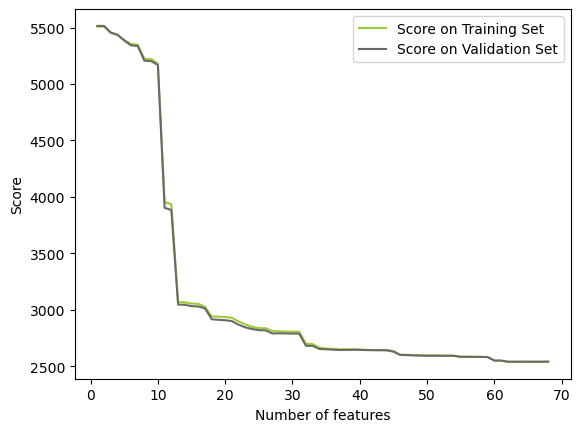

Lowest score of MAE is with number of features: 66
Score with 66 features: 2541.448070


In [71]:
# extract to list to then plot
train_score_list = [record["train_MAE"] for record in records]
val_score_list = [record["val_MAE"] for record in records]

# plot
plt.plot(list(range(1,69)), train_score_list, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1,69)), val_score_list, label="Score on Validation Set", color='dimgray')
plt.xlabel("Number of features")
plt.ylabel("Score")
plt.legend()
plt.show()

print("Lowest score of MAE is with number of features: %d" %n_feat)
print("Score with %d features: %f" % (n_feat, high_score))

- Altough the lowest score is with 66 features, we can say the model reaches his plateu at 61 features, so there is no advantage in adding more complexity and staying around 60 features

In [67]:
model_61_features = Pipeline([
        ("prep", preprocessor),
        ("rfe", RFE(estimator=LinearRegression(), n_features_to_select=61)),
        ("linreg", LinearRegression()),
    ])

model_61_features.fit(X_train, y_train_transformed) 

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('winsor',
                                                                   CustomWinsorizer(variables=['tax'])),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log1p_skewed',
                                                                   FunctionTransformer(func=<function log1p_selective at 0x000001D25D3453A0>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['mileage', 'tax', 'mpg',
                                                   'engineSize', 'car_age',
                                                   'mileage_per_y...
                                                 ('model_collap',
                                                  Pipeline(steps=[('select',
                                                                   ColumnSelector(column='model')),
                                                                  ('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('rare',
                                                                   RareLabelGrouper(column='model')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['model'])])),
                ('rfe',
                 RFE(estimator=LinearRegression(), n_features_to_select=61)),
                ('linreg', LinearRegression())])

## Model and evaluation

The project focuses on a regression problem with the objective of predicting used car prices. The following ML algorithms were selected for evaluation: 
- **Linear Regression:** Used as a baseline model due to its simplicity and interpretability.
- **Lasso Regression:** Explored for its ability to perform automatic feature selection by driving some coefficients to zero.
- **Decision Tree Regressor:** Implemented to capture potential non-linear relationships and more complex interactions between features, ultimately yielding the best performance.

**Assessment Strategy:** A consistent holdout split with a fixed random_state was maintained throughout the work to ensure reproducibility and avoid data leakage.

We start by implementing the optimal model (for linear regression) identified in the previous section.

In [49]:
pred_log = best_model.predict(X_val) 
pred_original_scale = np.expm1(pred_log)

In [50]:
pred_log_2 = model_61_features.predict(X_val) 
pred_original_scale_2 = np.expm1(pred_log_2)

#### Metrics

- Primary metric: **MAE**, because it is in price units, offering direct interpretability, and is less sensitive to outliers compared with other metrics (ex:MSE).

- Secondary: **RMSE** (penalizes large errors) and **R²** (variance explained, for context).

In [51]:
mae = mean_absolute_error(y_val, pred_original_scale)
mse = mean_squared_error(y_val, pred_original_scale)
rmse = mse ** 0.5
r2 = r2_score(y_val, pred_original_scale)
print("\n--- Model Performance (Best RFE) ---")
print(f"Main Metric (MAE): {high_score:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")


--- Model Performance (Best RFE) ---
Main Metric (MAE): 2541.4481
RMSE: 4408.5824
R2 Score: 0.8005


In [52]:
mae = mean_absolute_error(y_val, pred_original_scale_2)
mse = mean_squared_error(y_val, pred_original_scale_2)
rmse = mse ** 0.5
r2 = r2_score(y_val, pred_original_scale_2)
print("\n--- Model Performance (61 features) ---")
print(f"Main Metric (MAE): {score_61:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")


--- Model Performance (61 features) ---
Main Metric (MAE): 2541.5884
RMSE: 4408.2778
R2 Score: 0.8006


#### Other models

In [57]:
models_to_test = {
    "Lasso": LassoCV(cv=5, random_state=44),
    "DecisionTree": DecisionTreeRegressor(random_state=44)
}

high_score_2 = None
best_model_2 = None
best_model_2_name = ""
records = []

for name, model in models_to_test.items():
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model),
    ])

    pipe.fit(X_train, y_train_transformed)
    pred_log = pipe.predict(X_val)    
    pred_original_scale = np.expm1(pred_log)

    #metrics
    mae = mean_absolute_error(y_val, pred_original_scale)
    mse = mean_squared_error(y_val, pred_original_scale)
    rmse = mse ** 0.5
    r2 = r2_score(y_val, pred_original_scale)

    records.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

    if (high_score_2 is None) or (mae < high_score_2):
        high_score_2 = mae
        best_model_2 = pipe
        best_model_2_name = name

print("Results for all models:")
results_df = pd.DataFrame(records).sort_values(by="MAE").reset_index(drop=True)
print(results_df)

print(f"Best model: {best_model_2_name}")
print(f"MAE metric for the best model: {high_score_2:.4f}")

TypeError: got an unexpected keyword argument 'squared'

In [ ]:
pred_log = best_model_2.predict(X_val) 
pred_original_scale = np.expm1(pred_log)

#### Plot some visualizations

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=pred_original_scale, alpha=0.6)
lims = [min(y_val.min(), pred_original_scale.min()), max(y_val.max(), pred_original_scale.max())]
plt.plot(lims, lims, color='red', linestyle='--', linewidth=2)

plt.title('Actual vs Predicted Car price')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

In [ ]:
residuals = y_val - pred_original_scale

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pred_original_scale, y=residuals, alpha=0.6)

plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.title('Residuals vs Predicted Car Prices')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=50)
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#Export the best model for use in test.csv dataset
#joblib.dump(best_model_2, 'best_model')